# Recovery of $\dot{x}(t) = e^{-x}\log(t)-t^2$

### Import Packages

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from math import *
import copy
from scipy.integrate import odeint
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import random
from mpl_toolkits.mplot3d import Axes3D
from math import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from torch.utils.data import DataLoader, Dataset
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
device = torch.device("cuda:0")
dtype = torch.float
np.random.seed(seed= 85989)

### Generate Data

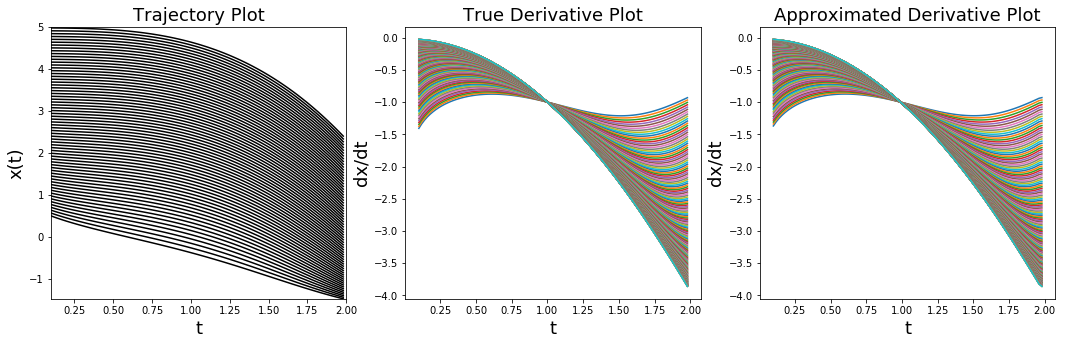

In [84]:
#Read data from .csv file
approx_sol = pd.read_csv('./e__-x log(t)-t__2/approx_sol_e__-x log(t)-t__2.csv', sep=',',header=None)
approx_solut = approx_sol.to_numpy()

#Data properties
components = 1 #spatial dimensions
deltat = 1/50 
tStop =  2
t = np.arange(0.1, tStop, deltat) #time steps of solution
time_steps = len(t)
n_initial_cond = approx_solut.shape[0] #number of initial conditions for solutions

#Read True RHS from .csv file
true_der =pd.read_csv('./e__-x log(t)-t__2/True_RHS_e__-x log(t)-t__2.csv', sep=',',header=None)
true_der = true_der.to_numpy()

#Read Difference Quotients from .csv file
Diff_quot =pd.read_csv('./e__-x log(t)-t__2/DiffQuot_e__-x log(t)-t__2.csv', sep=',',header=None)
Diff_quot = Diff_quot.to_numpy()

#Plot solution, True RHS, RHS approximation with difference quotients
fig = plt.figure(figsize = (18,5))
ax = fig.add_subplot(131)
x_low = np.min(approx_solut[:,:])
x_top = np.max(approx_solut[:,:])
plt.title('Trajectory Plot', fontsize = 18)
plt.xlabel('t', fontsize = 18)
plt.ylabel('x(t)', fontsize = 18)
plt.ylim(x_low, x_top)
plt.xlim(0.1, 2)
which_traj = np.arange(0, n_initial_cond, 3).tolist()
for i in which_traj:
    plt.plot(t, approx_solut[i,:],color = 'k')

ax = fig.add_subplot(132)
plt.title('True Derivative Plot', fontsize = 18)
plt.xlabel('t', fontsize = 18)
plt.ylabel('dx/dt', fontsize = 18)
for i in range(int(n_initial_cond)):
    plt.plot(t, true_der[i,:])

ax = fig.add_subplot(133)
plt.title('Approximated Derivative Plot', fontsize = 18)
plt.xlabel('t', fontsize = 18)
plt.ylabel('dx/dt', fontsize = 18)
for i in range(int(n_initial_cond)):
    plt.plot(t, Diff_quot[i,:])


### Extend solution by odd extension on the t boundaries:
In order to obrain a good approximation of the derivative on the t boundaries using difference quotients, we extend the solution by odd estension on the left and on the right of the time interval.

In [85]:
#Define functions that extend solution oddly on left and right of t interval
def left_odd_ext(xleft,x):
    Lext_x = 2*xleft - x
    return Lext_x[::-1]
    
def right_odd_ext(xright,x):
    Rext_x = 2*xright - x
    return  Rext_x[::-1]
    
def extend_sol_matrix(t, sol_matrix, ext_amount):
    tleft = t[0]
    Lext_t = (2*tleft - t[1:ext_amount])[::-1]
    tright = t[-1]
    Rext_t = (2*tright - t[-ext_amount:-1])[::-1]
    xleft = sol_matrix[0,0]
    xright = sol_matrix[0,-1]
    Lxsimm = sol_matrix[0,1:ext_amount]
    Rxsimm = sol_matrix[0,-ext_amount:-1]
    Lext_sol = left_odd_ext(xleft,Lxsimm)
    Rext_sol = right_odd_ext(xright,Rxsimm)
    
    left_ext = Lext_sol
    right_ext = Rext_sol
    for i in range(1,n_initial_cond):
        xleft = sol_matrix[i,0]
        xright = sol_matrix[i,-1]
        Lxsimm = sol_matrix[i,1:ext_amount]
        Rxsimm = sol_matrix[i,-ext_amount:-1]
        
        Lext_sol = left_odd_ext(xleft,Lxsimm)
        left_ext = np.vstack((left_ext,Lext_sol))
        
        Rext_sol = right_odd_ext(xright,Rxsimm)
        right_ext = np.vstack((right_ext,Rext_sol))
    extended_t = np.hstack((Lext_t,t, Rext_t))
    extended_approx_solut = np.hstack((left_ext,sol_matrix,right_ext))
    return extended_t, extended_approx_solut

### Add noise to solution trajectories and smooth out with splines to get derivative approximation:
To each solution point we add noise generated from a gaussian (whose variance is the percentage of noise added to the data) multiplied by the mean range of the trajecotores.
In order to generate reliable target data (derivative approximation) in presence of noise, we smooth the noisy solutions with Univariate Splines and compute derivative using difference quotients using the smoothed trajectories.

Noise = False


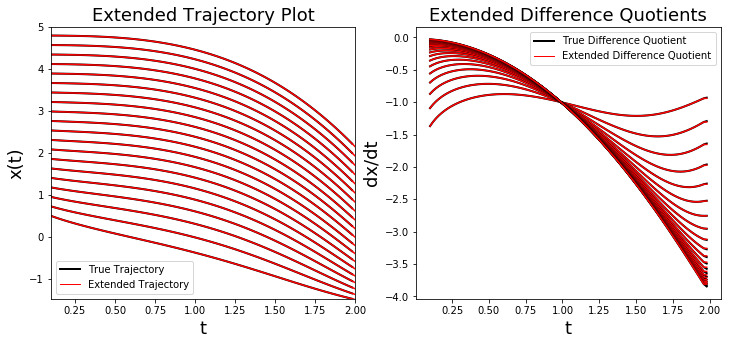

In [86]:
#Decide if we want to add noise or not
add_noise = False
print('Noise =', add_noise)

#We will add noise to a copy of the original data
approx_solut_noise_noex = copy.deepcopy(approx_solut)

# compute trajectories range as (max(traj)-min(traj)) then compute mea across all trajectories
#This is the mean solution range
maxmin=[]
for i in range(n_initial_cond):
    maxmin.append(np.max(approx_solut[i,:])-np.min(approx_solut[i,:]))
mean_range = np.mean(maxmin)


if add_noise:
    #add noise to extended trajecotry points
    noise_perc = 0.01 #noise percentage
    approx_solut_noise_noex += np.random.normal(0.0, noise_perc, (n_initial_cond,len(t))) * mean_range
    ext_amount = 2
    extended_T, extended_sol_noise = extend_sol_matrix(t, approx_solut_noise_noex, ext_amount)
    
    #smooth noisy data with splines to generate good difference quotients
    approx_sol_spline = np.zeros((n_initial_cond,len(extended_T)))
    for i in range(n_initial_cond):
        y = extended_sol_noise[i,:]
        spl = UnivariateSpline(extended_T, y, k = 4) 
        spl.set_smoothing_factor(0.5) #increase or decrease smoothness of spline (1: 1e06 2:0.5)
        approx_sol_spline[i,:] = spl(extended_T)
   
    #compute new difference quotients from smoothed data
    n_ext_times = len(extended_T)
    difference_quot_noise = np.zeros((n_initial_cond,n_ext_times))
    for i in range(n_initial_cond):
        for k in range(n_ext_times-1):
            difference_quot_noise[i,k] = (approx_sol_spline[i,k+1] - approx_sol_spline[i,k])/deltat #difference quotients
        difference_quot_noise[i,n_ext_times-1] = approx_sol_spline[i, n_ext_times-1] * np.cos(approx_sol_spline[i, n_ext_times-1]) 

    #Plot noisy data, spline-smoothed data, smoothed difference quotients
    which_traj = np.arange(0, n_initial_cond, 10).tolist()
    fig = plt.figure(figsize = (18,5))
    ax = fig.add_subplot(131)
    x_low = np.min(approx_solut[:,:])
    x_top = np.max(approx_solut[:,:])
    plt.title('Extended Noisy and True Trajectory Plot', fontsize = 18)
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('x(t)', fontsize = 18)
    plt.ylim(x_low, x_top)
    plt.xlim(0.1, 2)
    custom_lines = [Line2D([0], [0], color='k', lw=2), Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['True Trajectory', 'Noisy Trajectory'])
    for i in which_traj:
        plt.plot(t, approx_solut[i,:],color = 'k',linewidth = 2)
        plt.plot(extended_T, extended_sol_noise[i,:],c = 'r')

    ax = fig.add_subplot(132)
    plt.title('Spline-smoothed Trajectory Plot', fontsize = 18)
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('x(t)', fontsize = 18)
    custom_lines = [Line2D([0], [0], color='k', lw=2), Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['True Trajectory', 'Spline Trajectory'])
    for i in which_traj:
        plt.plot(extended_T, approx_sol_spline[i,:], color = 'r', lw=1)
        plt.plot(t, approx_solut[i,:],color = 'k',lw=2)

    ax = fig.add_subplot(133)
    plt.title('Smoothed Difference Quotient Plot', fontsize = 18)
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('dx/dt', fontsize = 18)
    custom_lines = [Line2D([0], [0], color='k', lw=2), Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['True Difference Quotient', 'Spline Difference Quotient'])
    for i in which_traj:
        plt.plot(t, Diff_quot[i,:],color = 'k',linewidth = 2)
        plt.plot(t, difference_quot_noise[i,ext_amount-1:-ext_amount+1],color = 'r')

    #Cut extended solutions to original dimension
    approx_sol_spline = approx_sol_spline[:,ext_amount-1:-ext_amount+1]
    difference_quot_noise = difference_quot_noise[:,ext_amount-1:-ext_amount+1]
    
#if we do not add any noise, we still extend at boundaries, but don't use splines
else: 
    noise_perc = 0
    #extend solution
    ext_amount = 2
    extended_T, extended_sol = extend_sol_matrix(t, approx_solut, ext_amount)
    
    #compute difference quotients on extended data
    n_ext_times = len(extended_T)
    difference_quot_ext = np.zeros((n_initial_cond,n_ext_times))
    for i in range(n_initial_cond):
        for k in range(n_ext_times-1):
            difference_quot_ext[i,k] = (extended_sol[i,k+1] - extended_sol[i,k])/deltat #difference quotients
        difference_quot_ext[i,n_ext_times-1] = extended_sol[i, n_ext_times-1] * np.cos(extended_sol[i, n_ext_times-1]) 
        
    #Plot extended data, difference quotients
    which_traj = np.arange(0, n_initial_cond, 10).tolist()
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(121)
    x_low = np.min(approx_solut[:,:])
    x_top = np.max(approx_solut[:,:])
    plt.title('Extended Trajectory Plot', fontsize = 18)
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('x(t)', fontsize = 18)
    plt.ylim(x_low, x_top)
    plt.xlim(0.1, 2)
    custom_lines = [Line2D([0], [0], color='k', lw=2), Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['True Trajectory', 'Extended Trajectory'])
    for i in which_traj:
        plt.plot(t, approx_solut[i,:],color = 'k',linewidth = 2)
        plt.plot(extended_T, extended_sol[i,:],color = 'r')

    ax = fig.add_subplot(122)
    plt.title('Extended Difference Quotients', fontsize = 18)
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('dx/dt', fontsize = 18)
    custom_lines = [Line2D([0], [0], color='k', lw=2), Line2D([0], [0], color='r', lw=1)]
    ax.legend(custom_lines, ['True Difference Quotient', 'Extended Difference Quotient'])
    for i in which_traj:
        plt.plot(t, Diff_quot[i,:],color = 'k',linewidth = 2)
        plt.plot(t, difference_quot_ext[i,ext_amount-1:-ext_amount+1],color = 'r')
    
    #cut back to original dimension
    difference_quot_ext = difference_quot_ext[:,ext_amount-1:-ext_amount+1]

### Divide into training and testing data

Noise = False
Total Points 19000
Number of Traning Points 15200
Number of Test Points 3800


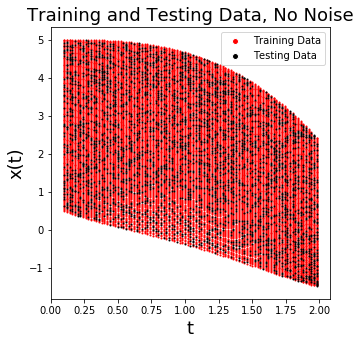

In [112]:
print('Noise =', add_noise)
if add_noise:
    inputs =approx_solut_noise_noex.reshape(-1,1) 
    t_copy = np.tile(t, n_initial_cond)
    input2 = t_copy.reshape(-1,1)
    inputs_time = np.append(inputs,input2,axis = 1)
    targets = difference_quot_noise.reshape(-1,1)
    all_points = np.arange(0, len(inputs),1).tolist()
    test_points =random.sample(all_points,int(inputs.shape[0]*0.2)) #
    train_points = list(set(all_points) - set(test_points))
    print('Total Points', len(all_points))
    print('Number of Traning Points', len(train_points))
    print('Number of Test Points', len(test_points))
    train_data_time = torch.from_numpy(inputs_time[train_points]).float()
    train_data = train_data_time.reshape(-1,2)
    train_expected = torch.from_numpy(targets[train_points,:].reshape(-1,1)).float()
    test_data_time = torch.from_numpy(inputs_time[test_points]).float()
    test_data = test_data_time.reshape(-1,2)
    test_expected = torch.from_numpy(targets[test_points,:].reshape(-1,1)).float()
    
    # Find normalization constants for relative error computation
    norm_const = abs(np.max(targets)-np.min(targets))
    
    #plot Training and testing Data
    fig = plt.figure(figsize=(5, 5))
    custom_lines = [Line2D([0], [0], color='w',marker ='o', markerfacecolor='r'), Line2D([0], [0], color='w',marker ='o', markerfacecolor='k')]
    plt.legend(custom_lines, ['Training Data', 'Testing Data'])
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('x(t)', fontsize = 18)
    plt.title('Training and Testing Data, with Noise', fontsize = 18)
    plt.scatter(train_data[:,1],train_data[:,0],c = 'r', s=1)
    plt.scatter(test_data[:,1],test_data[:,0],c = 'k', s=1)
    
else:
    inputs =approx_solut.reshape(-1,1) 
    t_copy = np.tile(t, n_initial_cond)
    input2 = t_copy.reshape(-1,1)
    inputs_time = np.append(inputs,input2,axis = 1)
    targets = difference_quot_ext.reshape(-1,1)
    all_points = np.arange(0, len(inputs),1).tolist()
    test_points =random.sample(all_points,int(inputs.shape[0]*0.2)) #select every 5 np.arange(0,len(inputs),5).tolist()
    train_points = list(set(all_points) - set(test_points))
    print('Total Points', len(all_points))
    print('Number of Traning Points', len(train_points))
    print('Number of Test Points', len(test_points))
    train_data_time = torch.from_numpy(inputs_time[train_points]).float()
    train_data = train_data_time.reshape(-1,2)
    train_expected = torch.from_numpy(targets[train_points,:].reshape(-1,1)).float()
    test_data_time = torch.from_numpy(inputs_time[test_points]).float()
    test_data = test_data_time.reshape(-1,2)
    test_expected = torch.from_numpy(targets[test_points,:].reshape(-1,1)).float()
    
    # Find normalization constants for relative error computation
    norm_const = abs(np.max(targets)-np.min(targets))
    
    #plot Training and testing Data
    fig = plt.figure(figsize=(5, 5))
    custom_lines = [Line2D([0], [0], color='w',marker ='o', markerfacecolor='r'), Line2D([0], [0], color='w',marker ='o', markerfacecolor='k')]
    plt.legend(custom_lines, ['Training Data', 'Testing Data'])
    plt.xlabel('t', fontsize = 18)
    plt.ylabel('x(t)', fontsize = 18)
    plt.title('Training and Testing Data, No Noise', fontsize = 18)
    plt.scatter(train_data[:,1],train_data[:,0],c = 'r', s=1)
    plt.scatter(test_data[:,1],test_data[:,0],c = 'k', s=1)

### Define Load Data Class

In [113]:
#Define LoadDataset
class LoadDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        inputs = self.x[idx, :]
        targets = self.y[idx, :]

        return inputs, targets


### Define Lipschitz Regularized Network

In [114]:
#Define Lipschitz Regularization

reg_param = 0.005 #set regularization parameter
how_many_points = 10 #how many points to estimate Lipschitz constant of network, has to be < batch size.

def Quot(input1, input2):
    input1 = input1.to(device)
    input2 = input2.to(device)
    model1 = Lip_Model(input1)
    model2 = Lip_Model(input2)
    Num = torch.norm(model1-model2,2)
    Den = torch.norm(input1-input2, 2)
    div = torch.div(Num,Den)
    return div.to(device)

#select how_many_points random points in the input and compute and approximate Lipschitz constant with them.
def Lip(input_matrix):
    which_points = random.sample(range(0, len(input_matrix)), how_many_points)    
    Quot_vec = torch.Tensor().reshape(-1,1).to(device)
    for in1 in range(len(which_points)):
        for in2 in range(in1+1, len(which_points)-1):
            first_pt = input_matrix[which_points[in1]]
            first_pt = first_pt.to(device)
            second_pt = input_matrix[which_points[in2]]
            second_pt = second_pt.to(device)
            Quot_vec = torch.cat((Quot_vec,Quot(first_pt, second_pt).reshape(-1,1)))
    maxim =(torch.max(Quot_vec)).reshape(-1,1)
    return maxim.to(device)

In [168]:
#Define Lipschitz Regularized Model

epochs = 15
batch_size = 100
input_size = 2 #columns in input matrix point
hidden_size1 = 10
hidden_size2 = 30
hidden_size3 = 10
output_size = 1 


class LipNet(torch.nn.Module):
    """Lipschitz Regularized Network, 8 layers, LeakyReLU activation,
    input size is number of columns in input matrix, here is 2 for (t,x)
    output size is 1, value of RHS at given couple (t,x), hidden_size1, hidden_size2 can be chosen by user"""
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LipNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_size,   hidden_size1, bias=True)
        self.linear2 = torch.nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.linear3 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear4 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear5 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear6 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear7 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear8 = torch.nn.Linear(hidden_size2, output_size,  bias=True)
        
        self.lrelu = torch.nn.LeakyReLU()
        
    def forward(self, x):
        x = self.lrelu(self.linear1(x))
        x = self.lrelu(self.linear2(x))
        x = self.lrelu(self.linear3(x))
        x = self.lrelu(self.linear4(x))
        x = self.lrelu(self.linear5(x))
        x = self.lrelu(self.linear6(x))
        x = self.lrelu(self.linear7(x))
        x = self.linear8(x)
        return x
    
Lip_Model = LipNet(input_size, hidden_size1, hidden_size2, output_size).to(device)

### Train Lipschitz Regularized Netowrk

In [169]:
#load dataset to use when training 
dataset = LoadDataset(train_data, train_expected) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 
#select Optimizer and parameters
optimizer = torch.optim.Adam(Lip_Model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False) 

loss = torch.nn.MSELoss() 
train_loss_Lip = 1
loss_list_Lip = []
l2_loss_list_Lip = []
train = train_data.to(device)
train_exp = train_expected.to(device)
for epoch in range(epochs):
    if train_loss_Lip - 0.003>0: #stoppoing condition on Lipschitz loss
        Lip_Model.train()
        if epoch % 5 == 0: #decrease learning rate every 5 epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10.
        batch_idx = 0
        for input_data, targets in dataloader:
            input_data = input_data.to(device)
            train_loss_Lip = loss(Lip_Model(train), train_exp).detach().cpu().numpy()
            if train_loss_Lip - 0.003<0: #stoppoing condition on Lipschitz loss
                break
            preds = Lip_Model(input_data) 
            targets = targets.to(device)
            l2_loss = loss(preds, targets)
            Lips =  reg_param * Lip(input_data)
            lo = l2_loss +  Lips
            loss_l2 = l2_loss.clone().detach().cpu().numpy()
            
            #print L2 Loss and Lipschitz loss every epoch
            if batch_idx == 1 and epoch % 1 == 0:
                percent = ((epoch+1) / epochs)
                print('Epoch: {0}, L2Loss: {1:2.6f}, Train_Loss: {2:2.6f} '.format(epoch,loss_l2, train_loss_Lip))

            #optimizer step
            optimizer.zero_grad()
            lo.backward()
            optimizer.step()

            batch_idx += 1
    else:
        break

Epoch: 0, L2Loss: 2.986562, Train_Loss: 3.118372 
Epoch: 1, L2Loss: 0.159508, Train_Loss: 0.199457 
Epoch: 2, L2Loss: 0.007554, Train_Loss: 0.007697 
Epoch: 3, L2Loss: 0.002501, Train_Loss: 0.004763 
Epoch: 4, L2Loss: 0.003070, Train_Loss: 0.003515 


### Evaluate Lipschitz Regularized Model on Test Data

In [170]:
Lip_Model.eval()

train_data = train_data.to(device)
train_expected = train_expected.to(device)
test_data = test_data.to(device)
test_expected = test_expected.to(device)

#evaluate the model on test data
train_loss_Lip = loss(Lip_Model(train_data), train_expected).detach().cpu().numpy()
print('Train MSE Lipschitz',train_loss_Lip)
test_loss_Lip = loss(Lip_Model(test_data), test_expected).detach().cpu().numpy()
print('Test MSE Lipschitz',test_loss_Lip)
print('Normalized Test MSE: {0:1.4f}%'.format((test_loss_Lip/norm_const)*100))
gen_gap_Lip = test_loss_Lip - train_loss_Lip
print('Generalization Gap Lipschitz : {0:1.2e}'.format(gen_gap_Lip))

Train MSE Lipschitz 0.0029248577
Test MSE Lipschitz 0.003232387
Normalized Test MSE: 0.0852%
Generalization Gap Lipschitz : 3.08e-04


### Define Non-Regularized Network

In [187]:
#Define Non-Regularized Model

batch_size = 100
input_size = 2
hidden_size1 = 10
hidden_size2 = 30
hidden_size3 = 10
output_size = 1 


class ElisaNet(torch.nn.Module):
    """Non-Regularized Network, 8 layers, LeakyReLU activation,
    input size is number of columns in input matrix, here is 2 for (t,x)
    output size is 1, value of RHS at given couple (t,x), hidden_size1, hidden_size2 can be chosen by user
    """
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ElisaNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_size,   hidden_size1, bias=True)
        self.linear2 = torch.nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.linear3 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear4 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear5 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear6 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear7 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear8 = torch.nn.Linear(hidden_size2, output_size,  bias=True)
        
        self.lrelu = torch.nn.LeakyReLU()
        
    def forward(self, x):
        x = self.lrelu(self.linear1(x))
        x = self.lrelu(self.linear2(x))
        x = self.lrelu(self.linear3(x))
        x = self.lrelu(self.linear4(x))
        x = self.lrelu(self.linear5(x))
        x = self.lrelu(self.linear6(x))
        x = self.lrelu(self.linear7(x))
        x = self.linear8(x)
        return x
    
Elisa_Model = ElisaNet(input_size, hidden_size1, hidden_size2, output_size).to(device)

### Train Non-Regularized Model 

In [188]:
#load dataset to use when training 
dataset = LoadDataset(train_data, train_expected) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 
#define optimized and Parameters
optimizer = torch.optim.Adam(Elisa_Model.parameters(), lr=0.5e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) 

loss = torch.nn.MSELoss() 
train_loss = 1
l2_loss_list = []
L2_loss_Mean = 1

for epoch in range(epochs):
    if train_loss - np.around(train_loss_Lip,5)> 0: #stop when train_loss is comparable with Lipschitz train loss
        Elisa_Model.train()
        if epoch % 2 == 0: #decrease learning rate every 5 epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 2.
        batch_idx = 0
        for input_data, targets in dataloader:
            if train_loss- np.around(train_loss_Lip,5) < 0: #stopping criteria
                break
            train = train_data.to(device)
            train_exp = train_expected.to(device)
            train_loss = loss(Elisa_Model(train), train_exp).detach().cpu().numpy()
            test_loss = loss(Elisa_Model(test_data), test_expected).detach().cpu().numpy()
            input_data = input_data.to(device)
            preds = Elisa_Model(input_data) 
            targets = targets.to(device)
            lo = loss(preds, targets)
            loss_cpu = lo.clone().detach().cpu().numpy()

            if batch_idx == 1 and epoch % 1 == 0:
                percent = ((epoch+1) / epochs)
                print('Epoch: {0}   Train Loss: {1:2.6f}'.format(epoch,  train_loss))
                
            #optimizer step
            optimizer.zero_grad()
            lo.backward()
            optimizer.step()

            batch_idx += 1

    else:
        break

Epoch: 0   Train Loss: 2.654852
Epoch: 1   Train Loss: 0.008644


### Evaluate Non-Regularized Model on Test Data

In [189]:
Elisa_Model.eval()
loss = torch.nn.MSELoss()
train_data = train_data.to(device)
train_expected = train_expected.to(device)
test_data = test_data.to(device)
test_expected = test_expected.to(device)

#evaluate the model on test data
test_loss = loss(Elisa_Model(test_data), test_expected).detach().cpu().numpy()
train_loss = loss(Elisa_Model(train_data), train_expected).detach().cpu().numpy()
gen_gap = test_loss - train_loss

print('Train MSE',train_loss)
print('Generalization Gap', gen_gap)
print('Test MSE',test_loss)
print('Normalized Test MSE: {0:1.4f}%'.format((test_loss/norm_const)*100))
print('\n')
print('Comparison with Lipschitz Network')
print('Normalized Training MSE: {0:1.4f}%'.format((train_loss_Lip/norm_const)*100))
print('Normalized Test MSE: {0:1.4f}%'.format((test_loss/norm_const)*100))
print('Normalized Test MSE Lipschitz: {0:1.4f}%'.format((test_loss_Lip/norm_const)*100))
print('Generalization Gap', gen_gap)
print('Generalization Gap Lipschitz', gen_gap_Lip)


Train MSE 0.002947481
Generalization Gap 0.0004983344
Test MSE 0.0034458155
Normalized Test MSE: 0.0908%


Comparison with Lipschitz Network
Normalized Training MSE: 0.0771%
Normalized Test MSE: 0.0908%
Normalized Test MSE Lipschitz: 0.0852%
Generalization Gap 0.0004983344
Generalization Gap Lipschitz 0.00030752923


### Plot recovery on test data
The color represent the value of the RHS at any given point (t,x). We plot the true function, the recovered function with the non regularized network and the recovered function with the Lipschitz Regularized Network.

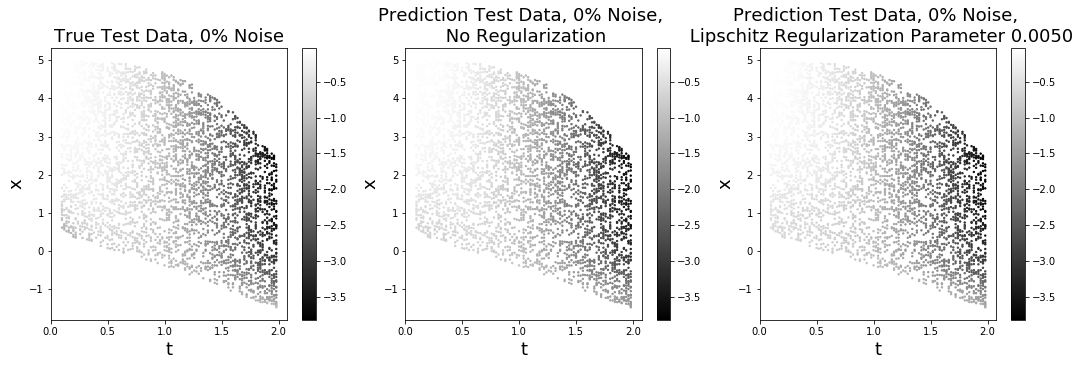

In [190]:
test_data_plot = test_data.detach().cpu().numpy()
train_data_plot =train_data.detach().cpu().numpy()

colT = test_expected.detach().cpu().numpy()
vminT = np.min(colT)
vmaxT = np.max(colT)
colP = Elisa_Model(test_data).detach().cpu().numpy()
vminP = np.min(colP)
vmaxP = np.max(colP)
colPL = Lip_Model(test_data).detach().cpu().numpy()
vminPL = np.min(colPL)
vmaxPL = np.max(colPL)

colT.astype(float) 
norm_colT = colT
colT=[]
for col in norm_colT:
    colT.append(col[0])
colT = np.asarray(colT)

colP.astype(float) 
norm_colP =colP
colP=[]
for col in norm_colP:
    colP.append(col[0])
colP = np.asarray(colP)

colPL.astype(float) 
norm_colPL =colPL
colPL=[]
for col in norm_colPL:
    colPL.append(col[0])
colPL = np.asarray(colPL)

#Plot Recovered RHS on test data
fig  = plt.figure(figsize=(18,5))

fig.add_subplot(1, 3, 1)
plt.title('True Test Data, %1.0f%% Noise'%(noise_perc*100),fontsize=18)
plt.xlabel('t',fontsize=18)
plt.ylabel('x',fontsize=18)
sc = plt.scatter(test_data_time[:,1],test_data_time[:,0],s=2,c=colT,vmin=vminT,vmax=vmaxT,cmap='gray')
plt.colorbar(sc)


fig.add_subplot(1, 3, 2)
plt.title('Prediction Test Data, %1.0f%% Noise, \n No Regularization'%(noise_perc*100),fontsize=18)
plt.xlabel('t',fontsize=18)
plt.ylabel('x',fontsize=18)
sc=plt.scatter(test_data_time[:,1], test_data_time[:,0],s=2,c=colP,vmin=vminT,vmax=vmaxT,cmap='gray')
plt.colorbar(sc)

fig.add_subplot(1, 3, 3)
plt.title('Prediction Test Data, %1.0f%% Noise,'%(noise_perc*100) +' \n Lipschitz Regularization Parameter %1.4f' %reg_param,fontsize=18)
plt.xlabel('t',fontsize=18)
plt.ylabel('x',fontsize=18)
sc=plt.scatter(test_data_time[:,1], test_data_time[:,0],s=2,c=colPL,vmin=vminT,vmax=vmaxT,cmap='gray')
plt.colorbar(sc)


### Plot error on test data
The gray level represent the value of the test error at any given point (t,x). The darker the color, the lower the error ay any given couple (t,x). We plot the error for the non regularized network and the error for the the Lipschitz Regularized Network for comparison

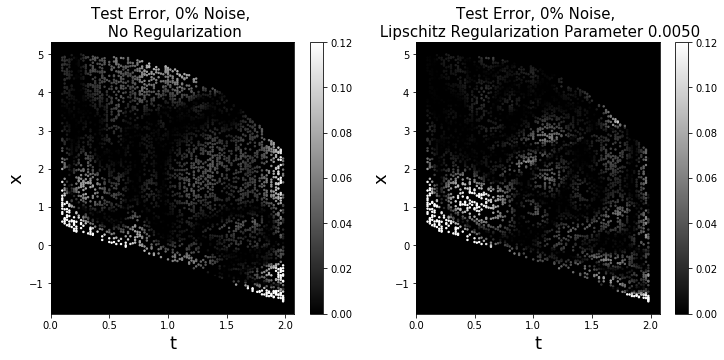

In [191]:
colE = np.abs(test_expected.detach().cpu().numpy() - Elisa_Model(test_data).detach().cpu().numpy())
vminE = np.min(colE)
vmaxE = np.max(colE)

colEL = np.abs(test_expected.detach().cpu().numpy() - Lip_Model(test_data).detach().cpu().numpy())
vminEL = np.min(colEL)
vmaxEL = np.max(colEL)

colE.astype(float) 
norm_colE = colE
colE=[]
for col in norm_colE:
    colE.append(col[0])
colE = np.asarray(colE)

colEL.astype(float) 
norm_colEL =colEL
colEL=[]
for col in norm_colEL:
    colEL.append(col[0])
colEL = np.asarray(colEL)

fig  = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1, 2, 1)
plt.title('Test Error, %1.0f%% Noise, \n No Regularization'%(noise_perc*100),fontsize=15)
plt.xlabel('t',fontsize=18)
plt.ylabel('x',fontsize=18)
sc = ax.scatter(test_data_time[:,1],test_data_time[:,0],s=2,c=colE,vmin=0,vmax=1.2e-01, cmap = 'gray')
ax.set_facecolor('xkcd:black')
ax.set_facecolor((0, 0, 0))
plt.colorbar(sc)

ax = fig.add_subplot(1, 2, 2)
plt.title('Test Error, %1.0f%% Noise,'%(noise_perc*100)+' \n Lipschitz Regularization Parameter %1.4f' %reg_param, fontsize=15)
plt.xlabel('t',fontsize=18)
plt.ylabel('x',fontsize=18)
sc=ax.scatter(test_data_time[:,1], test_data_time[:,0],s=2,c=colEL,vmin=0,vmax=1.2e-01, cmap = 'gray')
ax.set_facecolor('xkcd:black')
ax.set_facecolor((0, 0, 0))
plt.colorbar(sc)

### Recovery on non-trajecotry data
We now compute the recovered function on non trajecotry couples (t,x). We do the recovery on the domain where the training trajecotries are defined.

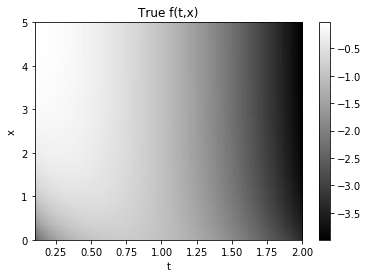

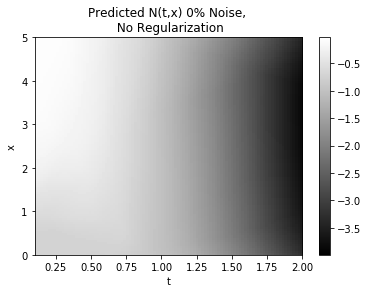

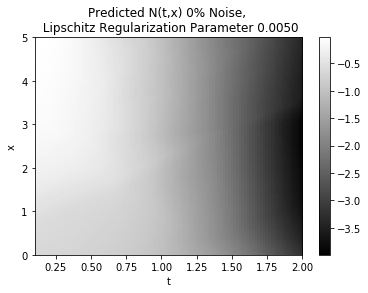

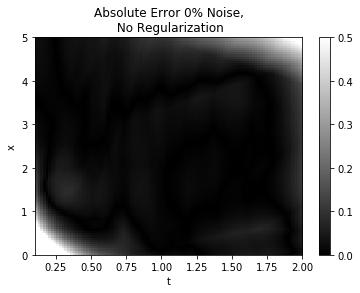

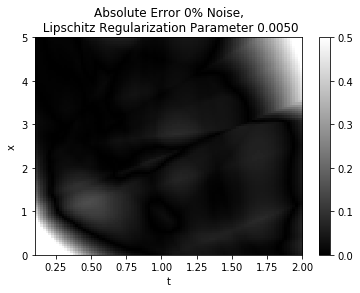

Mean Relative Error 1.19%
Mean Relative Error Lipschitz 1.51%


In [192]:
n= 100 #grid points where we do the recovery

# Define real RHS
def z_func(t,x):
    return np.log(t) * e ** (-x) - t ** 2

#define recovery domain boundaries
x_low = 0
x_top = 5
t_low = 0.1
t_top = 2.

#generate grid of x and t in the recovery domain
x = np.linspace(x_low, x_top, n)
time1 = np.linspace(t_low, t_top, n)
T,X = meshgrid(time1, x)

#compute true RHS on grid
Z = z_func(T, X)

#Generate input for netowrk
new_X = X.reshape(-1,1)
new_T = T.reshape(-1,1)
net_input = torch.from_numpy(np.append(new_X,new_T,axis = 1)).to(device)
#compute non-regularized network output and reshape so that it has the same form as Z
y_coord_new_pred = Elisa_Model((net_input).float())
y_coord_new_pred = y_coord_new_pred.detach().cpu().numpy()
y_coord_new_pred= y_coord_new_pred.reshape(n,n)
#compute Lipschitz regularized network output and reshape so that it has the same form as Z
y_coord_Lip = Lip_Model((net_input).float())
y_coord_Lip = y_coord_Lip.detach().cpu().numpy()
y_coord_Lip= y_coord_Lip.reshape(n,n)

#plot color bar of Error
plt.imshow(Z,origin='lower',interpolation='nearest', extent=[t_low,t_top,x_low,x_top], aspect = 'auto', cmap = 'gray');
plt.colorbar()
plt.title('True f(t,x)')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

plt.imshow(y_coord_new_pred,origin='lower',interpolation='nearest',vmin = np.min(Z), vmax = np.max(Z), extent=[t_low,t_top,x_low,x_top], aspect = 'auto', cmap = 'gray');
plt.colorbar()
plt.title('Predicted N(t,x) %1.0f%% Noise, \n No Regularization' %(noise_perc*100))
plt.xlabel('t')
plt.ylabel('x')
plt.show()

plt.imshow(y_coord_Lip,origin='lower',interpolation='nearest',vmin = np.min(Z), vmax = np.max(Z), extent=[t_low,t_top,x_low,x_top], aspect = 'auto', cmap = 'gray');
plt.colorbar()
plt.title('Predicted N(t,x) %1.0f%% Noise,'%(noise_perc*100)+' \n Lipschitz Regularization Parameter %1.4f' %reg_param)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

plt.imshow(abs(Z - y_coord_new_pred),origin='lower',interpolation='nearest',vmin = 0, vmax = 0.5, extent=[t_low,t_top,x_low,x_top], aspect = 'auto', cmap = 'gray');
plt.colorbar()
plt.title('Absolute Error %1.0f%% Noise,\n No Regularization' %(noise_perc*100))
plt.xlabel('t')
plt.ylabel('x')
plt.show()

plt.imshow(abs(Z - y_coord_Lip),origin='lower',interpolation='nearest',vmin = 0, vmax = 0.5, extent=[t_low,t_top,x_low,x_top], aspect = 'auto', cmap = 'gray');
plt.colorbar()
plt.title('Absolute Error %1.0f%% Noise,'%(noise_perc*100)+ '\n Lipschitz Regularization Parameter %1.4f' %reg_param)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

print('Mean Relative Error {0:1.2f}%'.format(100*np.mean(abs(Z - y_coord_new_pred))/(np.abs(np.max(Z)-np.min(Z)))))
print('Mean Relative Error Lipschitz {0:1.2f}%'.format(100*np.mean(abs(Z - y_coord_Lip))/(np.abs(np.max(Z)-np.min(Z)))))
